In [19]:
# Download TorchVision repo to use some files from
# references/detection
!git clone https://github.com/pytorch/vision.git
!cd vision
!git checkout v0.8.2

!cp ./vision/references/detection/utils.py ./
!cp ./vision/references/detection/transforms.py ./
!cp ./vision/references/detection/coco_eval.py ./
!cp ./vision/references/detection/engine.py ./
!cp ./vision/references/detection/coco_utils.py ./

!pip install cython
# Install pycocotools, the version by default in Colab
!pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
!pip install -U albumentations
!pip install -U opencv-python

# Run git clone from the command line within colab notebook environment
!git clone https://github.com/tanishasethi1/hackcmu23.git

fatal: destination path 'vision' already exists and is not an empty directory.
fatal: not a git repository (or any of the parent directories): .git
  Cloning https://github.com/cocodataset/cocoapi.git to /tmp/pip-req-build-belw7ed1
  Running command git clone --filter=blob:none --quiet https://github.com/cocodataset/cocoapi.git /tmp/pip-req-build-belw7ed1
  Resolved https://github.com/cocodataset/cocoapi.git to commit 8c9bcc3cf640524c4c20a9c40e89cb6a2f2fa0e9
  Preparing metadata (setup.py) ... done
fatal: destination path 'hackcmu23' already exists and is not an empty directory.


In [20]:
# from google.colab import drive
# drive.mount('/content/drive')

In [21]:
import os
import math
import numpy as np
import torch
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
# from engine import train_one_epoch, evaluate
import utils
import transforms as T
import albumentations as A
import cv2
import time
from albumentations.pytorch.transforms import ToTensorV2
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from  sklearn.model_selection import KFold
import random

test_hyperparams = False
train = False

In [22]:
class CraterDataset(object):
    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to
        # ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(self.root, "images/"))))
        self.annots = list(sorted(os.listdir(os.path.join(self.root, "labels/"))))
        self.classes = ['Background','Crater']

    # Converts boundry box formats, this version assumes single class only!
    def convert_box_cord(self,bboxs, format_from, format_to, img_shape):
        if format_from == 'normxywh':
            if format_to == 'xyminmax':
                xw = bboxs[:, (1, 3)] * img_shape[1]
                yh = bboxs[:, (2, 4)] * img_shape[0]
                xmin = xw[:, 0] - xw[:, 1] / 2
                xmax = xw[:, 0] + xw[:, 1] / 2
                ymin = yh[:, 0] - yh[:, 1] / 2
                ymax = yh[:, 0] + yh[:, 1] / 2
                coords_converted = np.column_stack((xmin, ymin, xmax, ymax))

        return coords_converted

    def __getitem__(self, idx):
        # load images and boxes
        img_path = os.path.join(self.root, "images", self.imgs[idx])
        annot_path = os.path.join(self.root, "labels", self.annots[idx])
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB).astype(np.float32)
        img= img/255.0

        # retrieve bbox list and format to required type,
        # if annotation file is empty, fill dummy box with label 0
        if os.path.getsize(annot_path) != 0:
            bboxs = np.loadtxt(annot_path, ndmin=2)
            bboxs = self.convert_box_cord(bboxs, 'normxywh', 'xyminmax', img.shape)
            num_objs = len(bboxs)
            bboxs = torch.as_tensor(bboxs, dtype=torch.float32)
            # there is only one class
            labels = torch.ones((num_objs,), dtype=torch.int64)
            # suppose all instances are not crowd
            iscrowd = torch.zeros((num_objs,), dtype=torch.int64)
        else:
            bboxs = torch.as_tensor([[0, 0, 640, 640]], dtype=torch.float32)
            labels = torch.zeros((1,), dtype=torch.int64)
            iscrowd = torch.zeros((1,), dtype=torch.int64)

        area = (bboxs[:, 3] - bboxs[:, 1]) * (bboxs[:, 2] - bboxs[:, 0])
        image_id = torch.tensor([idx])

        target = {}
        target["boxes"] = bboxs
        target["labels"] = labels
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        if self.transforms is not None:
            sample = self.transforms(image=img,
                                     bboxes=target['boxes'],
                                     labels=labels)
        img = sample['image']
        target['boxes'] = torch.tensor(sample['bboxes'])
        target['labels'] = torch.tensor(sample['labels'])
        if target['boxes'].ndim == 1:
            target['boxes'] = torch.as_tensor([[0, 0, 640, 640]], dtype=torch.float32)
            target['labels'] = torch.zeros((1,), dtype=torch.int64)
        return img, target

    def __len__(self):
        return len(self.imgs)

In [23]:
def get_model_bbox(num_classes):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    return model

In [24]:
def get_transform(train):
    if train:
        return A.Compose([
            # A.Flip(p=0.5),
            # A.RandomResizedCrop(height=640,width=640,p=0.4),
            # # A.Perspective(p=0.4),
            # A.Rotate(p=0.5),
            # # A.Transpose(p=0.3),
            ToTensorV2(p=1.0)],
            bbox_params=A.BboxParams(format='pascal_voc',min_visibility=0.4, label_fields=['labels']))
    else:
        return A.Compose([ToTensorV2(p=1.0)],
                         bbox_params=A.BboxParams(format='pascal_voc', min_visibility=0.5, label_fields=['labels']))

In [25]:
def reset_weights(m):
  '''
    Try resetting model weights to avoid
    weight leakage.
  '''
  for layer in m.children():
    if hasattr(layer, 'reset_parameters'):
        print(f'Reset trainable parameters of layer = {layer}')
        layer.reset_parameters()

In [26]:
# Function to visualize bounding boxes in the image
def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1, 1)
    fig.set_size_inches(5, 5)
    a.imshow(img.permute((1,2,0)))
    for box in (target['boxes']):
        x, y, width, height = box[0], box[1], box[2] - box[0], box[3] - box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 edgecolor='b',
                                 facecolor='none',
                                 clip_on=False)
        a.annotate('Crater', (x,y-20), color='blue', weight='bold',
                   fontsize=10, ha='left', va='top')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()

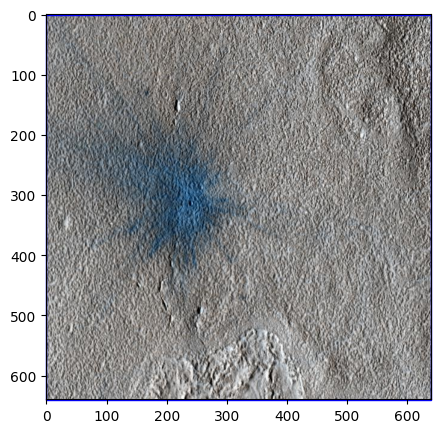

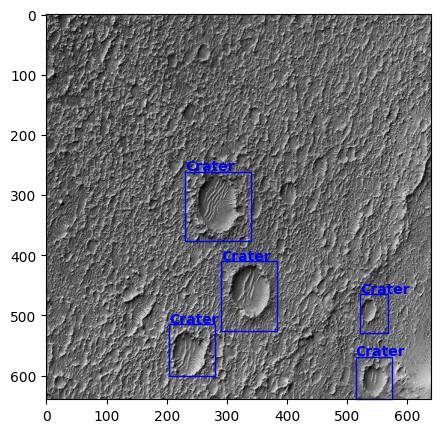

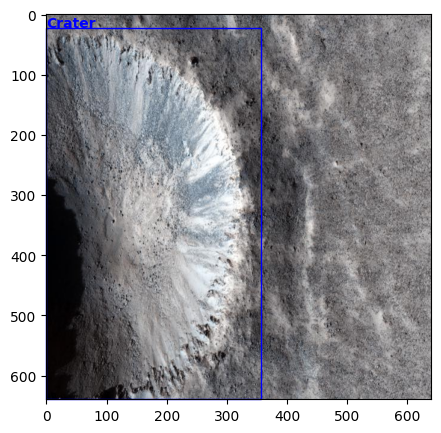

In [27]:
dataset = CraterDataset('hackcmu23/craters/train', get_transform(train=True))
# Prints an example of image with annotations
for i in random.sample(range(1, 100), 3):
    img, target = dataset[i]
    plot_img_bbox(img, target)

In [28]:
import math
import sys
import time

import torch
import torchvision.models.detection.mask_rcnn
import utils
from coco_eval import CocoEvaluator
from coco_utils import get_coco_api_from_dataset


def train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq, scaler=None):
    model.train()
    metric_logger = utils.MetricLogger(delimiter="  ")
    metric_logger.add_meter("lr", utils.SmoothedValue(window_size=1, fmt="{value:.6f}"))
    header = f"Epoch: [{epoch}]"

    lr_scheduler = None
    if epoch == 0:
        warmup_factor = 1.0 / 1000
        warmup_iters = min(1000, len(data_loader) - 1)

        lr_scheduler = torch.optim.lr_scheduler.LinearLR(
            optimizer, start_factor=warmup_factor, total_iters=warmup_iters
        )

    for images, targets in metric_logger.log_every(data_loader, print_freq, header):
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) if isinstance(v, torch.Tensor) else v for k, v in t.items()} for t in targets]
        with torch.cuda.amp.autocast(enabled=scaler is not None):
            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

        # reduce losses over all GPUs for logging purposes
        loss_dict_reduced = utils.reduce_dict(loss_dict)
        losses_reduced = sum(loss for loss in loss_dict_reduced.values())

        loss_value = losses_reduced.item()

        if not math.isfinite(loss_value):
            print(f"Loss is {loss_value}, stopping training")
            print(loss_dict_reduced)
            sys.exit(1)

        optimizer.zero_grad()
        if scaler is not None:
            scaler.scale(losses).backward()
            scaler.step(optimizer)
            scaler.update()
        else:
            losses.backward()
            optimizer.step()

        if lr_scheduler is not None:
            lr_scheduler.step()

        metric_logger.update(loss=losses_reduced, **loss_dict_reduced)
        metric_logger.update(lr=optimizer.param_groups[0]["lr"])

    return metric_logger, loss_value


def _get_iou_types(model):
    model_without_ddp = model
    if isinstance(model, torch.nn.parallel.DistributedDataParallel):
        model_without_ddp = model.module
    iou_types = ["bbox"]
    if isinstance(model_without_ddp, torchvision.models.detection.MaskRCNN):
        iou_types.append("segm")
    if isinstance(model_without_ddp, torchvision.models.detection.KeypointRCNN):
        iou_types.append("keypoints")
    return iou_types


@torch.inference_mode()
def evaluate(model, data_loader, device):
    n_threads = torch.get_num_threads()
    # FIXME remove this and make paste_masks_in_image run on the GPU
    torch.set_num_threads(1)
    cpu_device = torch.device("cpu")
    model.eval()
    metric_logger = utils.MetricLogger(delimiter="  ")
    header = "Test:"

    coco = get_coco_api_from_dataset(data_loader.dataset)
    iou_types = _get_iou_types(model)
    coco_evaluator = CocoEvaluator(coco, iou_types)

    for images, targets in metric_logger.log_every(data_loader, 100, header):
        images = list(img.to(device) for img in images)

        if torch.cuda.is_available():
            torch.cuda.synchronize()
        model_time = time.time()
        outputs = model(images)

        outputs = [{k: v.to(cpu_device) for k, v in t.items()} for t in outputs]
        model_time = time.time() - model_time

        res = {target["image_id"]: output for target, output in zip(targets, outputs)}
        evaluator_time = time.time()
        coco_evaluator.update(res)
        evaluator_time = time.time() - evaluator_time
        metric_logger.update(model_time=model_time, evaluator_time=evaluator_time)

    # gather the stats from all processes
    metric_logger.synchronize_between_processes()
    print("Averaged stats:", metric_logger)
    coco_evaluator.synchronize_between_processes()

    # accumulate predictions from all images
    coco_evaluator.accumulate()
    coco_evaluator.summarize()
    torch.set_num_threads(n_threads)
    return coco_evaluator

In [29]:
# train on the GPU or on the CPU, if a GPU is not available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

if test_hyperparams:
  all_kfolds = [2, 3, 4, 5]
  lrs = [0.001, 0.005, 0.01, 0.1]
  num_epochs = 5


  def train(k_folds, lr, num_epochs):
    # our dataset has two classes only - background and crater
    num_classes = 2
    # use our dataset and defined transformations
    dataset = CraterDataset('hackcmu23/craters/train', get_transform(train=True))
    dataset_val = CraterDataset('hackcmu23/craters/test', get_transform(train=False))

    # Define the K-fold Cross Validator
    kfold = KFold(n_splits=k_folds, shuffle=True)

    # Start print
    print('--------------------------------')

    # K-fold Cross Validation model evaluation
    for fold, (train_ids, val_ids) in enumerate(kfold.split(dataset)):
        print(f'FOLD {fold}')
        print('--------------------------------')

        dataset_subset = torch.utils.data.Subset(dataset, list(train_ids))
        dataset_val_subset = torch.utils.data.Subset(dataset_val, list(val_ids))

        # define training and validation data loaders
        data_loader = torch.utils.data.DataLoader(
                dataset_subset, batch_size=8, shuffle=True, num_workers=2,
            collate_fn=utils.collate_fn)

        data_loader_val = torch.utils.data.DataLoader(
            dataset_val_subset, batch_size=1, shuffle=False, num_workers=2,
            collate_fn=utils.collate_fn)

        # get the model using our helper function
        model = get_model_bbox(num_classes)

        #model.apply(reset_weights) # Check if beneficial

        # move model to the right device
        model.to(device)

        # construct an optimizer
        params = [p for p in model.parameters() if p.requires_grad]
        optimizer = torch.optim.SGD(params, lr=0.005,  # Check if beneficial
                                    momentum=0.9, weight_decay=0)

        # and a learning rate scheduler
        lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                                        step_size=10,
                                                        gamma=0.1)

        # let's train!
        for epoch in range(num_epochs):

            # train for one epoch, printing every 50 iterations
            metric_logger, loss_value = train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=50)
            # update the learning rate
            lr_scheduler.step()

        return model, data_loader_val, device, loss_value


  min_loss = float("inf")
  min_k = 1
  for k_folds in all_kfolds:
      model, data_loader_val, device, loss_value = train(k_folds, 0.005, num_epochs)
      if loss_value < min_loss:
        min_loss = loss_value
        min_k = k_folds

  min_loss = float("inf")
  min_lr = 1
  for lr in lrs:
      model, data_loader_val, device, loss_value = train(min_k, lr, num_epochs)
      if loss_value < min_loss:
        min_loss = loss_value
        min_lr = lr

else:
  min_k = 3
  min_lr = 0.1

In [30]:
print(min_k, min_lr)

3 0.1


In [34]:
if train:
  num_epochs = 50
  model, data_loader_val, device, loss_value = train(min_k, lr, num_epochs)
  print(loss_value)

  # Saving the last model
  save_path = os.path.join(f'Crater_noaug_sgd_2batch-lastepoch{num_epochs-1}.pth')
  torch.save(model.state_dict(), save_path)
  print(f'model from last epoch(no.{num_epochs-1}) saved')
  print(loss_value)
else:
  loss_value = 0.482059029960221
  model = torch.load(f'Crater_noaug_sgd_2batch-lastepoch{num_epochs-1}.pth')
  print(model)

OrderedDict([('backbone.body.conv1.weight', tensor([[[[ 1.3335e-02,  1.4664e-02, -1.5351e-02,  ..., -4.0896e-02,
           -4.3034e-02, -7.0755e-02],
          [ 4.1205e-03,  5.8477e-03,  1.4948e-02,  ...,  2.2060e-03,
           -2.0912e-02, -3.8517e-02],
          [ 2.2331e-02,  2.3595e-02,  1.6120e-02,  ...,  1.0281e-01,
            6.2641e-02,  5.1977e-02],
          ...,
          [-9.0349e-04,  2.7767e-02, -1.0105e-02,  ..., -1.2722e-01,
           -7.6604e-02,  7.8453e-03],
          [ 3.5894e-03,  4.8006e-02,  6.2051e-02,  ...,  2.4267e-02,
           -3.3662e-02, -1.5709e-02],
          [-8.0029e-02, -3.2238e-02, -1.7808e-02,  ...,  3.5359e-02,
            2.2439e-02,  1.7077e-03]],

         [[-1.8452e-02,  1.1415e-02,  2.3850e-02,  ...,  5.3736e-02,
            4.4022e-02, -9.4675e-03],
          [-7.7273e-03,  1.8890e-02,  6.7981e-02,  ...,  1.5956e-01,
            1.4606e-01,  1.1999e-01],
          [-4.6013e-02, -7.6075e-02, -8.9648e-02,  ...,  1.2108e-01,
            1.